In [1]:
# Task 1: Import The Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

The original image has length = 300, width = 451, dimension = 3


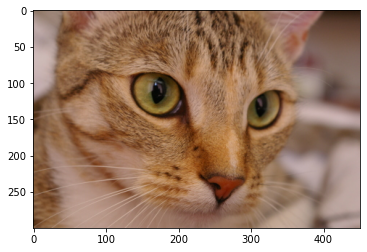

In [2]:
# Task 2: Read the Image file
img = mpimg.imread('chelsea.ppm')
(l, w, d) = img.shape

plt.imshow(img)

print(f'The original image has length = {l}, width = {w}, dimension = {d}')

The padded image has length = 304, width = 456, and color planes = 3.


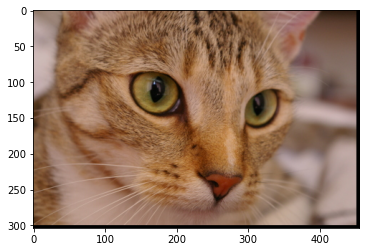

In [3]:
# Task 3: Pad the Image
# Perform zero padding if required
window_size = 8
img_pad  = np.pad(img, pad_width=[(0, window_size - l%window_size),(0, window_size - w%window_size), (0, 0)], mode='constant')

# Store the dimensions of the padded image
(length, width, depth) = img_pad.shape

# Check results
plt.imshow(img_pad)
print(f'The padded image has length = {length}, width = {width}, and color planes = {depth}.')

In [4]:
## YCbCr conversion matrix
rgb_to_yCbCr = np.array([[ 0.299, -0.168736,  0.5],
                          [0.587, -0.331264, -0.418688],
                          [ 0.114, 0.5, -0.081312]])

In [5]:
# Task 4: Transform the Image to YCbCr
# Tranformation
yCbCr_img = np.matmul(img_pad, rgb_to_yCbCr)

# Adjust the chrominance for encoding
yCbCr_img[:,:,1] += 128
yCbCr_img[:,:,2] += 128


In [6]:
# Task  5: Subsample the Image Chrominance
# Save the luminance
Y_420_img = yCbCr_img[:, :, 0] 

# Subsample the chrominance
Cb_420_img = np.zeros((length >> 1, width >> 1))
Cr_420_img = np.zeros((length >> 1, width >> 1))

for i in range(0, length, 2):
    for j in range(0, width, 2):
        Cb_420_img[i//2,j//2] = np.average(yCbCr_img[i:i+2, j:j+2, 1])
        Cr_420_img[i//2,j//2] = np.average(yCbCr_img[i:i+2, j:j+2, 2])

In [7]:
# Task  6: Write Image Data on a File
with open("C:/project/Image-Compression-Through-Subsampling-and-Interpolation/enc_chelsea.ycbcr", 'wb') as f:
    np.array([l, w, d]).astype('int64').tofile(f)
    (Y_420_img.astype('uint8')).flatten().tofile(f)
    (Cb_420_img.astype('uint8')).flatten().tofile(f)
    (Cr_420_img.astype('uint8')).flatten().tofile(f)

In [8]:
# Task 7: Read and Adjust Image Dimensions from Encoded File
# Read image dimensions from the encoded file
with open("C:/project/Image-Compression-Through-Subsampling-and-Interpolation/enc_chelsea.ycbcr",'rb') as f_full:
    (dec_l, dec_w, dec_d) = np.fromfile(f_full, dtype=np.int64, count=3, sep="")

# Dimension adjustment for zero padding
length = (dec_l//8+1)*8
width = (dec_w//8+1)*8
depth = dec_d

In [9]:
length

304

In [10]:
width

456

In [11]:
depth

3

In [12]:
# Task 8: Read File Data
# prepare data structures to read data
res = length*width
dec_full = np.zeros(res+(res >> 1))
yCbCr_dec = np.zeros((length, width, depth))
CbCr_dec = np.zeros((length >> 1, width >> 1, depth - 1))

with open("C:/project/Image-Compression-Through-Subsampling-and-Interpolation/enc_chelsea.ycbcr",'rb') as f_full:
    dec_full = np.fromfile(f_full, dtype=np.uint8, offset=24, count=-1, sep="")
# 1D to 3D conversion
yCbCr_dec[:,:,0] = dec_full[0:res].reshape((length,width))
CbCr_dec[:,:,0] = dec_full[res:(res+(res >> 2))].reshape((length >> 1, width >> 1))
CbCr_dec[:,:,1] = dec_full[(res+(res >> 2)):(res+(res >> 1))].reshape((length >> 1, width >> 1))

In [13]:
# Task 9: Interpolate the Chrominace Component
CbCr_dec_full = np.zeros((length, width, depth - 1))
# Interpolation
for i in range(length >> 1):
    for j in range(width >> 1):
        CbCr_dec_full[2*i:2*i+2,2*j:2*j+2,0] = CbCr_dec[i,j,0]
        CbCr_dec_full[2*i:2*i+2,2*j:2*j+2,1] = CbCr_dec[i,j,1]

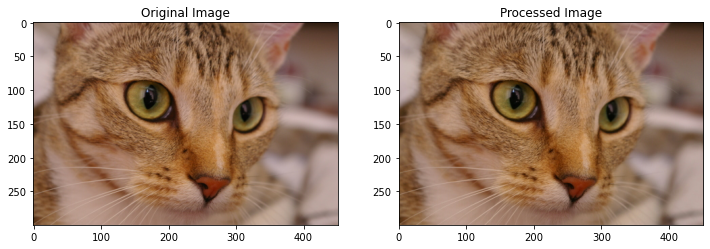

In [14]:
## RGB conversion matrix
yCbCr_to_rgb = np.array([[ 1.0, 1.0, 1.0],
                       [0.0, -0.344136, 1.772],
                       [ 1.402, -0.714136 , 0.0]])

# Task 10: Inverse-Transform the Image
yCbCr_dec[:,:,1] = CbCr_dec_full[:,:,0] - 128
yCbCr_dec[:,:,2] = CbCr_dec_full[:,:,1] - 128

# Inverse transform to RGB
rtv_img = np.matmul(yCbCr_dec, yCbCr_to_rgb)/255.0

# Clip to range
np.putmask(rtv_img, rtv_img > 1.0, 1.0)
np.putmask(rtv_img, rtv_img < 0.0, 0.0)

# Remove zero padding
decoded_img = rtv_img[0:dec_l, 0:dec_w, :]

# Plot the images
fig, ax = plt.subplots(1, 2, figsize = (12, 12))

ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[1].imshow(decoded_img)
ax[1].set_title('Processed Image')

plt.show()

In [15]:
# Task 11: Evaluate Compression Ratio
input_file_name = "chelsea.ppm"
enc_file_name = "enc_chelsea.ycbcr"

# Get the stats of both original and reconstructed images
input_file_stats = os.stat(input_file_name)
enc_file_stats = os.stat(enc_file_name)

# Check what you have achieved
print(f'Input file size in bytes is {input_file_stats.st_size}.')
print(f'Encoded file size in bytes is {enc_file_stats.st_size}.')
print(f'Compression ratio is {(enc_file_stats.st_size/input_file_stats.st_size)*100} %.')

Input file size in bytes is 405915.
Encoded file size in bytes is 207960.
Compression ratio is 51.23240087210377 %.
